In [ ]:
Python
Задание 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#загрузим группы участников теста
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
#проверяем наличие пропущенных значений
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [5]:
#загрузим дополнительные группы
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg', sep = ',')

In [6]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
groups_add.isnull().sum()

id     0
grp    0
dtype: int64

In [8]:
#соединим их вместе
groups_final = pd.concat([groups, groups_add], sort = False, axis = 0)

In [9]:
groups_final.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [10]:
groups_final.shape

(74576, 2)

In [12]:
#загрузим данные по тем студентам, которые были активны в период проведения A/B теста
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep = ';')

In [13]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.shape

(8341, 1)

In [19]:
#создадим датафрейм с данными по только активным студентам, т.к. остальные нам не интересны
active_studs = active_studs.rename(columns={'student_id': 'id'})
only_active = active_studs.merge(groups_final, how = 'left', on='id')

In [20]:
#все присоединилось нормально, строк не стало меньше
only_active.shape

(8341, 2)

In [14]:
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep = ';')

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [23]:
#присоединим нашу таблицу с оплатами, заменим пустые значения для студентов, которые ничего не оплачивали на 0
checks = checks.rename(columns={'student_id': 'id'})
checks.shape

final_table = only_active.merge(checks, how = 'left', on='id')
final_table['rev'].fillna(0, inplace=True)
final_table

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


In [24]:
final_table.dtypes

id       int64
grp     object
rev    float64
dtype: object

In [25]:
#на каждого пользователя только 1 значение в таблице, то есть нам не нужно их группировать и считать сумму по каждому id
final_table.id.nunique()

8341

In [26]:
#проверим, сколько в среднем мы получили revenue с каждого пользователя в тестовой и контрольной группе
final_table.groupby('grp', as_index = False) \
    .agg({'rev':'mean'}) \
    .rename(columns={'rev': 'avg_revenue_per_user'})

,grp,avg_revenue_per_user
0,A,47.347204
1,B,58.058798


In [27]:
#проверим, сколько в среднем мы получили revenue с каждого ПЛАТЯЩЕГО пользователя в тестовой и контрольной группе
final_table.query('rev > 0 ') \
    .groupby('grp', as_index = False) \
    .agg({'rev':'mean'}) \
    .rename(columns={'rev': 'avg_revenue_per_paying_user'})

,grp,avg_revenue_per_paying_user
0,A,933.589744
1,B,1257.878992


In [28]:
#Итак, по предварительным подсчетам мы стали получать больше денег с пользователей из группы, где введена новая механика оплаты, однако нужно проверить, являются ли различия значимыми

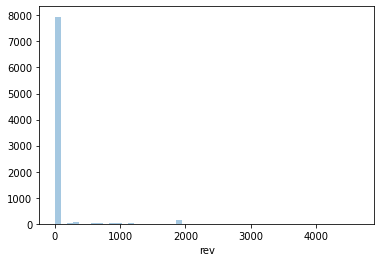

In [33]:
#перед тем как проверять распределения на нормальность и запускать t-test, построим быстрый график чтобы посмотреть на форму распределения
sns.distplot(final_table.rev, bins = 50, kde = False)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


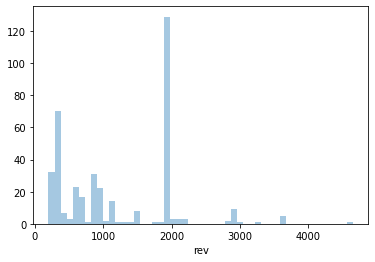

In [32]:
#получилось очень много нулевых значений в прошлой таблице, поэтому удалим неплатящих пользователей и построим заново
only_paying_users = final_table.query('rev > 0')
sns.distplot(only_paying_users.rev, bins = 50, kde = False)

In [ ]:
#Распределения даже на картинках далеки от нормальных, поэтому применять тест Шапиро-Уилка и проверять их на нормальность смысла особо нет. Сразу перейдем к сравнению средних. T-test нам здесь уже не подойдет, поэтому придется использовать его непараметрический аналог - Критерий Манна-Уитни

In [111]:
final_table = final_table.sort_values(by = ['rev'])
only_paying_users = only_paying_users.sort_values(by = ['rev'])

In [109]:
#импортируем наш критерий
from scipy.stats import mannwhitneyu

In [110]:
mannwhitneyu(final_table[final_table['grp'] == 'A']['rev'].values, final_table[final_table['grp'] == 'B']['rev'].values)

MannwhitneyuResult(statistic=5252113.0, pvalue=0.5099747992861601)

In [112]:
mannwhitneyu(only_paying_users[only_paying_users['grp'] == 'A']['rev'].values, only_paying_users[only_paying_users['grp'] == 'B']['rev'].values)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

In [ ]:
#По результатам мы видим, что различие в средней полученной прибыли на пользователя среди всех пользователей статистически не значимо, однако значимо когда мы говорим только о тех пользователях, которые совершили покупку. Скорее всего в тестовой группе больше тех, кто покупку за анализируемый период не совершил.
#Проверим конверсию в покупку в обеих группах чтобы подтвердить наше предположение

In [113]:
#для контрольной группы
round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'A' )].shape[0]/final_table[final_table['grp'] == 'A' ].shape[0]*100, 2)

5.07

In [114]:
#для тестовой
round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'B' )].shape[0]/final_table[final_table['grp'] == 'B' ].shape[0]*100, 2)

4.62

In [118]:
#на сколько % упала конверсия
round(round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'B')].shape[0]/final_table[final_table['grp'] == 'B' ].shape[0]*100, 2)/round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'A' )].shape[0]/final_table[final_table['grp'] == 'A' ].shape[0]*100, 2)*100-100, 2)

-8.88

In [ ]:
#Действительно, конверсия в покупку у тестовой группы снизилась. Получается, изменив механику оплаты мы значимо повысили среднюю прибыль с платящего пользователя, однако конвертироваться в покупку наши пользователи стали хуже, показатель снизился на 8,8%. То есть возможно, новая механика оплаты стала менее удобной, что привело к снижению конверсии в покупку. 
#Проверим, является ли данный результат статистически значимым, используя https://abtestguide.com/calc/. Уровень значимости - 0.2291, то есть конверсию мы уронили не столь сильно. Можно выкатывать новую версию, но держать в голове, что нужно будет последить за конверсией в дальнейшем


In [ ]:
Python
Задание 2

In [16]:
def group_add_count_metrics(file_path1, file_path2, file_path3, file_path4):
    #считываем первые 2 таблицы и присоединяем друг к другу
    groups = pd.read_csv(file_path1, sep = ';')
    groups_add = pd.read_csv(file_path1, sep = ',')
    groups_final = pd.concat([groups, groups_add], sort = False, axis = 0)
    
    #считываем третью таблицу с активными пользователями и присоединяем 
    active_studs = pd.read_csv(file_path3, sep = ';')
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    only_active = active_studs.merge(groups_final, how = 'left', on='id')
    
    #считываем и добавляем таблицу с оплатами и присоединяем 
    checks = pd.read_csv(file_path4, sep = ';')
    checks = checks.rename(columns={'student_id': 'id'})
    final_table = only_active.merge(checks, how = 'left', on='id')
    final_table['rev'].fillna(0, inplace=True)
    
    #строим таблицу с avg_revenue_per_user 
    avg_revenue_per_user = final_table.groupby('grp', as_index = False) \
    .agg({'rev':'mean'}) \
    .rename(columns={'rev': 'avg_revenue_per_user'})
    
    #строим таблицу с avg_revenue_per_paying_user 
    avg_revenue_per_paying_user = final_table.query('rev > 0 ') \
    .groupby('grp', as_index = False) \
    .agg({'rev':'mean'}) \
    .rename(columns={'rev': 'avg_revenue_per_paying_user'})
    #объединим их
    metrics_table = avg_revenue_per_user.merge(avg_revenue_per_paying_user, how = 'inner', on='grp')
    
    #посчитаем конверсию
    a = round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'A' )].shape[0]/final_table[final_table['grp'] == 'A' ].shape[0]*100, 2)   
    b = round(final_table[(final_table['rev'] > 0) & (final_table['grp'] == 'B' )].shape[0]/final_table[final_table['grp'] == 'B' ].shape[0]*100, 2)
    
    #добавим ее к кашей таблице
    conversion = pd.DataFrame([['A', a], ['B', b]])
    conversion = conversion.rename(columns={0: 'grp', 1:'conversion'})
    metrics_table = metrics_table.merge(conversion, how = 'left', on = 'grp')
    
    return metrics_table 

In [17]:
#проверка, работает ли наша функция 
file_path1 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg'
file_path2 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg'
file_path3 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg'
file_path4 = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ'
group_add_count_metrics(file_path1, file_path2, file_path3, file_path4)

,grp,avg_revenue_per_user,avg_revenue_per_paying_user,conversion
0,A,47.439739,933.589744,5.08
1,B,57.864567,1255.827487,4.61


In [ ]:
#Ура, работает! Теперь для визуализации

In [144]:
def charts_for_metrics(table):
    
    metrics_table = table
    #строим простенький график для визуализации avg_revenue per user и per paying user
    x1 = metrics_table.grp
    y1 = metrics_table.avg_revenue_per_user
    x2 = metrics_table.grp
    y2 = metrics_table.avg_revenue_per_paying_user

    fig, axes = plt.subplots(1, 2)
    fig.suptitle('Metrics for test and control groups')
    axes[0].bar(x1, y1)
    axes[1].bar(x2, y2)
    axes[0].set_title('avg_revenue_per_user')
    axes[1].set_title('avg_revenue_per_paying_user')
    axes[0].set_facecolor('white')
    axes[1].set_facecolor('white')

    fig.set_facecolor('white')
    fig.set_figheight(6)
    fig.set_figwidth(14)
    plt.show()

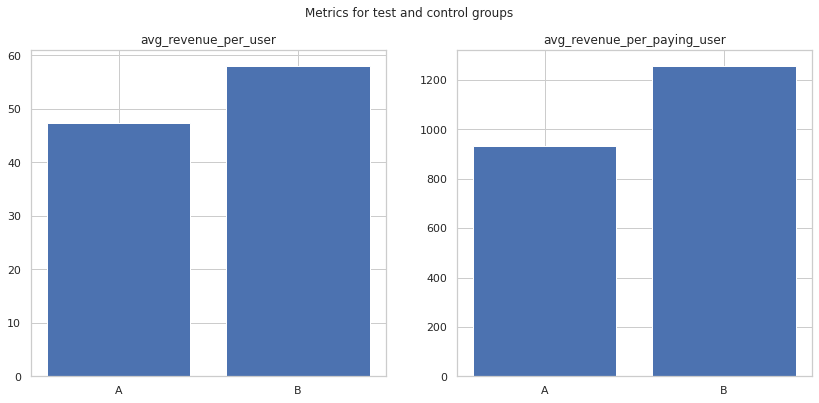

In [145]:
#сработало!
charts_for_metrics(metrics_table)

In [ ]:
Задание 2 -  SQL запросы
2.1 Очень усердные ученики

In [ ]:
SELECT DISTINCT student_id, day, hour, minutes, SUM(num_of_peas) OVER w AS num_of_peas_final 
FROM 
    (
    SELECT student_id, DAYOFMONTH(timestamp) AS day, HOUR(timestamp) AS hour, MINUTE(timestamp) AS minutes, COUNT(correct) AS num_of_peas
    FROM peas
    WHERE tostartofmonth(timestamp) = '2020-03-01' AND correct = True
    GROUP BY student_id, day, hour, minutes
        ORDER BY timestamp ASC 
    ) t1
WINDOW w AS
    (
    PARTITION BY student_id, DAYOFMONTH(timestamp), HOUR(timestamp), MINUTE(timestamp)
    ORDER BY timestamp ASC
    RANGE BETWEEN '30 minutes' PRECEDING AND '30 minutes' FOLLOWING
    )
GROUP BY student_id, day, hour, minutes
HAVING num_of_peas_final >=20


In [ ]:
Задание 2 -  SQL запросы
2.2 Оптимизация воронки

In [ ]:
SELECT test_grp, 
    SUM(money)/COUNT(DISTINCT studs.stud_id) AS ARPU, 

    SUM(money)/SUM(CASE WHEN money IS NULL THEN 0 ELSE 1 END) AS ARPPU, 

    SUM(CASE WHEN money IS NULL THEN 0 ELSE 1 END)/COUNT(DISTINCT studs.stud_id)*100 AS CR,  

    SUM(CASE WHEN money IS NULL THEN 0 ELSE 1 END)/SUM(CASE WHEN subjects IS NULL THEN 0 ELSE 1 END)*100 AS CR_active_to_purchase, 

    SUM(CASE WHEN subject = ‘math’ AND money IS NOT NULL THEN 1 ELSE 0 END)/SUM(CASE WHEN subject = ‘math’ AND subjects IS NOT NULL THEN 1 ELSE 0 END)*100 AS CR_active_math_to_buy_it

FROM studs LEFT JOIN 
    (
    SELECT DISTINCT checks.stud_id AS stud_id, SUM(money) AS money
    FROM checks
    GROUP BY stud_id
    ) AS checks ON studs.stud_id = checks.stud_id 
        LEFT JOIN 
    (
    SELECT DISTINCT stud_id AS active_id, COUNT(DISTINCT subject) AS subjects
    GROUP BY active_id
    FROM peas
    GROUP BY active_id
    ) AS active_table ON studs.stud_id = active_table.active_id
GROUP BY test_grp